In [ ]:
import os
from tqdm.notebook import tqdm
import json
import pandas as pd
from collections import defaultdict
from dateutil.parser import parse

def validate_game(game: dict) -> bool:
    try:
        if not isinstance(game.get("id"), int):
            return False

        if not isinstance(game.get("map", {}).get("id"), int):
            return False

        begin_at = game.get("begin_at")
        if not begin_at:
            return False
        try:
            parse(begin_at)
        except Exception:
            return False

        match = game.get("match", {})
        for key in ("league", "serie", "tournament"):
            if not match.get(key, {}).get("id"):
                return False

        players = game.get("players")
        if not players or not isinstance(players, list):
            return False

        team_players = defaultdict(set)
        for p in players:
            t_id = p.get("team", {}).get("id")
            p_id = p.get("player", {}).get("id")
            if not t_id or not p_id:
                return False
            team_players[t_id].add(p_id)

        team_ids = list(team_players.keys())
        if len(team_ids) != 2:
            return False

        if any(len(p_ids) != 5 for p_ids in team_players.values()):
            return False

        rounds = game.get("rounds", [])
        if not rounds or not isinstance(rounds, list):
            return False

        round_numbers = []
        for r in rounds:
            if not r.get("round"):
                return False
            if r.get("ct") not in team_ids or r.get("terrorists") not in team_ids:
                return False
            if r.get("winner_team") not in team_ids:
                return False
            round_numbers.append(r["round"])

        if not round_numbers or min(round_numbers) != 1 or max(round_numbers) < 16:
            return False

        return True

    except Exception:
        return False
    
from collections import defaultdict
from dateutil.parser import parse

def extract_game_info(game: dict) -> dict:
    """Extract key info from a game dictionary."""
    game_id = game.get("id")
    begin_at = parse(game.get("begin_at")) if game.get("begin_at") else None

    team_players = defaultdict(list)
    for p in game.get("players", []):
        team_id = p.get("team", {}).get("id")
        player_id = p.get("player", {}).get("id")
        if team_id and player_id:
            team_players[team_id].append(player_id)
    t1_id = sorted(list(team_players.keys()))[0]
    winner_id = pd.DataFrame.from_records(game["rounds"])["winner_team"].value_counts().idxmax()

    return {
        "id": game_id,
        "begin_at": begin_at,
        "team_players": dict(team_players)
        "target":int(t1_id==winner_id),
    }


data = []
for filename in tqdm(os.listdir("data/games_raw")):
    file_path = os.path.join("data/games_raw", filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            game = json.load(f)
        is_valid = validate_game(game)
        if is_valid:
            data.append(extract_game_info(game))
        
    except:
        pass
    
import pandas as pd
import numpy as np

# Sort and prepare data
data = (
    pd.DataFrame.from_records(data)
    .convert_dtypes()
    .sort_values(by="begin_at")
    .to_dict("records")
)

# Split into train/test
train_data = data[:-100]
test_data = data[-100:]

# Collect unique team and player IDs
team_ids, player_ids = set(), set()

for row in train_data:    
    for t_id, p_ids in row["team_players"].items():
        team_ids.add(t_id)
        for p_id in p_ids:
            player_ids.add(p_id)

print(f"Total unique teams: {len(team_ids)}")
print(f"Total unique players: {len(player_ids)}")

# Build ID lookup dicts
team_id_dict = dict(zip(sorted(list(team_ids)), range(len(team_ids))))
player_id_dict = dict(zip(sorted(list(player_ids)), range(len(player_ids))))

# Initialize matrices
team_bag_train = np.zeros((len(train_data), len(team_ids)), dtype=np.int8)
player_bag_train = np.zeros((len(train_data), len(player_ids)), dtype=np.int8)

# Fill matrices
for i, row in enumerate(train_data):
    t_ids = list(row["team_players"].keys())
    if len(t_ids) != 2:
        continue  # skip invalid games

    team1_id, team2_id = sorted(t_ids)

    # Teams
    team_bag_train[i, team_id_dict[team1_id]] = 1
    team_bag_train[i, team_id_dict[team2_id]] = -1

    # Players
    for p_id in row["team_players"][team1_id]:
        player_bag_train[i, player_id_dict[p_id]] = 1
    for p_id in row["team_players"][team2_id]:
        player_bag_train[i, player_id_dict[p_id]] = -1

print("✅ Team and player bag matrices built:")
print(f"  team_bag_train.shape = {team_bag_train.shape}")
print(f"  player_bag_train.shape = {player_bag_train.shape}")


  0%|          | 0/56493 [00:00<?, ?it/s]

In [7]:
import pandas as pd

Total unique teams: 1293
Total unique players: 4507


In [ ]:
import os
from tqdm.notebook import tqdm
import json
import pandas as pd
from collections import defaultdict
from dateutil.parser import parse

def validate_game(game: dict) -> bool:
    try:
        if not isinstance(game.get("id"), int):
            return False

        if not isinstance(game.get("map", {}).get("id"), int):
            return False

        begin_at = game.get("begin_at")
        if not begin_at:
            return False
        try:
            parse(begin_at)
        except Exception:
            return False

        match = game.get("match", {})
        for key in ("league", "serie", "tournament"):
            if not match.get(key, {}).get("id"):
                return False

        players = game.get("players")
        if not players or not isinstance(players, list):
            return False

        team_players = defaultdict(set)
        for p in players:
            t_id = p.get("team", {}).get("id")
            p_id = p.get("player", {}).get("id")
            if not t_id or not p_id:
                return False
            team_players[t_id].add(p_id)

        team_ids = list(team_players.keys())
        if len(team_ids) != 2:
            return False

        if any(len(p_ids) != 5 for p_ids in team_players.values()):
            return False

        rounds = game.get("rounds", [])
        if not rounds or not isinstance(rounds, list):
            return False

        round_numbers = []
        for r in rounds:
            if not r.get("round"):
                return False
            if r.get("ct") not in team_ids or r.get("terrorists") not in team_ids:
                return False
            if r.get("winner_team") not in team_ids:
                return False
            round_numbers.append(r["round"])

        if not round_numbers or min(round_numbers) != 1 or max(round_numbers) < 16:
            return False

        return True

    except Exception:
        return False
    
from collections import defaultdict
from dateutil.parser import parse

def extract_game_info(game: dict) -> dict:
    """Extract key info from a game dictionary."""
    game_id = game.get("id")
    begin_at = parse(game.get("begin_at")) if game.get("begin_at") else None

    team_players = defaultdict(list)
    for p in game.get("players", []):
        team_id = p.get("team", {}).get("id")
        player_id = p.get("player", {}).get("id")
        if team_id and player_id:
            team_players[team_id].append(player_id)
    t1_id = sorted(list(team_players.keys()))[0]
    winner_id = pd.DataFrame.from_records(game["rounds"])["winner_team"].value_counts().idxmax()

    return {
        "id": game_id,
        "begin_at": begin_at,
        "team_players": dict(team_players),
        "target":int(t1_id==winner_id),
    }


data = []
for filename in tqdm(os.listdir("data/games_raw")):
    file_path = os.path.join("data/games_raw", filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            game = json.load(f)
        is_valid = validate_game(game)
        if is_valid:
            data.append(extract_game_info(game))
        
    except:
        pass
    
import pandas as pd
import numpy as np

# Sort and prepare data
data = (
    pd.DataFrame.from_records(data)
    .convert_dtypes()
    .sort_values(by="begin_at")
    .to_dict("records")
)

# Split into train/test
train_data = data[:-100]
test_data = data[-100:]



  0%|          | 0/56493 [00:00<?, ?it/s]

In [30]:
X, y = [], []
for row in train_data:
    X.append(sorted(list(row["team_players"].keys()))), y.append(row["target"])

In [31]:
import numpy as np

class BagOfTeamPipeline:
    """
    Bag-of-Teams feature extractor.

    - fit(X, y): builds team ID dictionary and feature matrix.
      X: list of [team1_id, team2_id]
      y: list of binary labels (1 if team1 wins, 0 otherwise)

    - transform(X): accepts either:
        * a single [team1_id, team2_id], or
        * a list of such pairs [[t1, t2], [t3, t4], ...]
      and returns encoded vector(s).
    """

    def __init__(self):
        self.team_id_dict = {}
        self.X_bag = None
        self.y = None

    def fit(self, X: list[list[int]], y: list[int]):
        """Fit by building team dictionary and encoding matches."""
        # Collect all unique team IDs
        all_team_ids = {tid for match in X for tid in match}
        self.team_id_dict = {
            tid: idx for idx, tid in enumerate(sorted(all_team_ids))
        }

        # Build bag-of-teams feature matrix
        n_matches = len(X)
        n_teams = len(self.team_id_dict)
        self.X_bag = np.zeros((n_matches, n_teams), dtype=np.int8)

        for i, (team1_id, team2_id) in enumerate(X):
            self.X_bag[i, self.team_id_dict[team1_id]] = 1
            self.X_bag[i, self.team_id_dict[team2_id]] = -1

        self.y = np.array(y, dtype=np.int8)
        return self

    def transform(self, X):
        """
        Transform team pair(s) into bag-of-teams vector(s).
        - Accepts single [team1_id, team2_id] or list of such pairs.
        - Returns 1D or 2D numpy array.
        """
        n_teams = len(self.team_id_dict)

        
        # Multiple matches
        X_bag = np.zeros((len(X), n_teams), dtype=np.int8)
        for i, (team1_id, team2_id) in enumerate(X):
            if team1_id in self.team_id_dict:
                X_bag[i, self.team_id_dict[team1_id]] = 1
            if team2_id in self.team_id_dict:
                X_bag[i, self.team_id_dict[team2_id]] = -1
        return X_bag


In [32]:
b = BagOfTeamPipeline()
b.fit(X, y)

In [33]:
b.transform(X).shape

(37974, 1293)

In [37]:
X, y = [], []
for row in train_data:
    t1, t2 = sorted(row["team_players"].keys())
    X.append(sorted(row["team_players"][t1]) + sorted(row["team_players"][t2])), y.append(row["target"])

In [38]:
import numpy as np

class BagOfPlayerPipeline:
    """
    Bag-of-Players feature extractor.

    - fit(X, y): builds player ID dictionary and encodes matches.
      X: list of 10 player IDs (first 5 = team1, last 5 = team2)
      y: list of binary labels (1 if team1 wins, 0 otherwise)

    - transform(X): accepts either:
        * a single list of 10 player IDs, or
        * a list of such matches [[p1..p10], [p11..p20], ...]
      and returns encoded vector(s).
    """

    def __init__(self):
        self.player_id_dict = {}
        self.X_bag = None
        self.y = None

    def fit(self, X: list[list[int]], y: list[int]):
        """Fit by building player dictionary and encoding matches."""
        # Collect all unique player IDs
        all_player_ids = {pid for match in X for pid in match}
        self.player_id_dict = {
            pid: idx for idx, pid in enumerate(sorted(all_player_ids))
        }

        # Build bag-of-players feature matrix
        n_matches = len(X)
        n_players = len(self.player_id_dict)
        self.X_bag = np.zeros((n_matches, n_players), dtype=np.int8)

        for i, match in enumerate(X):
            if len(match) != 10:
                raise ValueError(f"Each match must have 10 players, got {len(match)}")
            
            # First 5 → +1 (team1), Last 5 → -1 (team2)
            for pid in match[:5]:
                if pid in self.player_id_dict:
                    self.X_bag[i, self.player_id_dict[pid]] = 1
            for pid in match[5:]:
                if pid in self.player_id_dict:
                    self.X_bag[i, self.player_id_dict[pid]] = -1

        self.y = np.array(y, dtype=np.int8)
        return self

    def transform(self, X):
        """
        Transform match(es) into bag-of-players vector(s).
        - Accepts a single list of 10 player IDs or multiple.
        """
        n_players = len(self.player_id_dict)

        # Single match → wrap into list
        if isinstance(X[0], int):
            X = [X]

        X_bag = np.zeros((len(X), n_players), dtype=np.int8)
        for i, match in enumerate(X):
            if len(match) != 10:
                raise ValueError(f"Each match must have 10 players, got {len(match)}")

            for pid in match[:5]:
                if pid in self.player_id_dict:
                    X_bag[i, self.player_id_dict[pid]] = 1
            for pid in match[5:]:
                if pid in self.player_id_dict:
                    X_bag[i, self.player_id_dict[pid]] = -1

        return X_bag


In [39]:
b = BagOfPlayerPipeline()
b.fit(X, y)

In [44]:
X_bag = b.transform(X)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit


In [ ]:
cross_val_score(, X_bag, np.array(y), cv = TimeSeriesSplit(5), scoring="roc_auc")

array([0.59780328, 0.62083473, 0.62788806, 0.65462604, 0.64010076])

In [ ]:
logit = LogisticRegression()
logit.fit(X_bag[:-100], )

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [50]:
(np.int32(logit.predict_proba(X_bag[-100:])[:, 1] > .5) == np.array(y)[-100:]).mean()

np.float64(0.69)

In [51]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 KB 8.9 MB/s eta 0:00:00


In [52]:
X

[[17525, 17539, 17540, 17542, 17570, 17808, 17809, 17811, 17833, 17834],
 [17525, 17539, 17540, 17542, 17570, 17808, 17809, 17811, 17833, 17834],
 [17520, 17523, 17555, 17627, 17650, 17497, 17498, 17499, 17500, 17543],
 [17520, 17523, 17555, 17627, 17650, 17497, 17498, 17499, 17500, 17543],
 [17520, 17523, 17555, 17627, 17650, 17808, 17809, 17811, 17833, 17834],
 [17525, 17539, 17540, 17542, 17570, 17497, 17498, 17499, 17500, 17543],
 [17520, 17523, 17555, 17627, 17650, 17808, 17809, 17811, 17833, 17834],
 [17525, 17539, 17540, 17542, 17570, 17497, 17498, 17499, 17500, 17543],
 [17520, 17523, 17555, 17627, 17650, 17808, 17809, 17811, 17833, 17834],
 [17526, 17545, 17561, 17563, 17564, 17513, 17515, 17516, 17568, 17569],
 [17507, 17508, 17510, 17517, 17524, 17512, 17548, 17549, 17550, 17566],
 [17526, 17545, 17561, 17563, 17564, 17513, 17515, 17516, 17568, 17569],
 [17507, 17508, 17510, 17517, 17524, 17512, 17548, 17549, 17550, 17566],
 [17513, 17515, 17516, 17568, 17569, 17507, 17508, 

Уникальных игроков: 4507
Train size: 37874, Validation size: 100
Augmented train size: 75748 (x2.0 от оригинала)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 16)    │     72,112 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_71 (Lambda)  │ (None, 5, 16)     │          0 │ player_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_72 (Lambda)  │ (None, 5, 16)     │          0 │ player_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_73 (Lambda)  │ (None, 16)        │          0 │ lambda_71[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_74 (Lambda)  │ (None, 16)        │          0 │ lambda_72[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_75 (Lambda)  │ (None, 16)        │          0 │ lambda_73[0][0],  │
│                     │                   │            │ lambda_74[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_76 (Lambda)  │ (None, 16)        │          0 │ lambda_73[0][0],  │
│                     │                   │            │ lambda_74[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64)        │          0 │ lambda_73[0][0],  │
│ (Concatenate)       │                   │            │ lambda_74[0][0],  │
│                     │                   │            │ lambda_75[0][0],  │
│                     │                   │            │ lambda_76[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │      4,160 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_42[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 32)        │      2,080 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 1)         │         33 │ dropout_29[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,641 (307.19 KB)

 Trainable params: 78,513 (306.69 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
579/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5614 - auc: 0.5566 - loss: 0.6907
Epoch 1: val_auc improved from None to 0.64943, saving model to best_model.h5


592/592 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5832 - auc: 0.5980 - loss: 0.6786 - val_accuracy: 0.6400 - val_auc: 0.6494 - val_loss: 0.6482
Epoch 2/50
579/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6402 - auc: 0.6861 - loss: 0.6365
Epoch 2: val_auc improved from 0.64943 to 0.72026, saving model to best_model.h5


592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6379 - auc: 0.6807 - loss: 0.6396 - val_accuracy: 0.6900 - val_auc: 0.7203 - val_loss: 0.6005
Epoch 3/50
583/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - auc: 0.7172 - loss: 0.6147
Epoch 3: val_auc improved from 0.72026 to 0.73287, saving model to best_model.h5


592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6545 - auc: 0.7088 - loss: 0.6204 - val_accuracy: 0.7200 - val_auc: 0.7329 - val_loss: 0.5896
Epoch 4/50
570/592 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6734 - auc: 0.7329 - loss: 0.6007
Epoch 4: val_auc did not improve from 0.73287
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6646 - auc: 0.7237 - loss: 0.6071 - val_accuracy: 0.6600 - val_auc: 0.7146 - val_loss: 0.5987
Epoch 5/50
579/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6790 - auc: 0.7434 - loss: 0.5910
Epoch 5: val_auc did not improve from 0.73287
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6754 - auc: 0.7376 - loss: 0.5950 - val_accuracy: 0.6800 - val_auc: 0.7175 - val_loss: 0.5989
Epoch 6/50
576/592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6821 - auc: 0.7492 - loss: 0.5821
Epoch 6: val_auc did not improve from 0.73287
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6778 - auc: 0.7435 - loss: 0.5881 - val_accuracy: 0.6700 - v

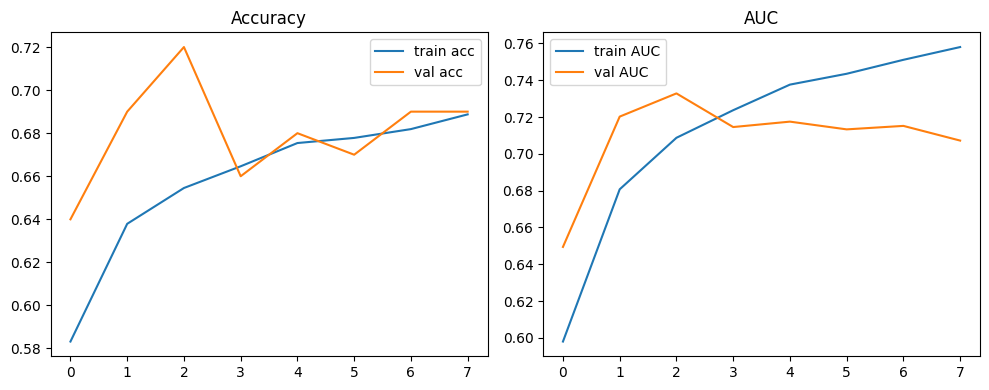

In [70]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Lambda, Dense, Dropout, Concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt


# ==== 1. Пример данных ====
# X = list[list[int]] (10 игроков = 5 на команду)
# y = list[int] (1 если победа первой команды, 0 иначе)

# ==== 2. Подготовка данных ====
all_players = sorted(set(p for match in X for p in match))
print("Уникальных игроков:", len(all_players))

player2idx = {pid: idx for idx, pid in enumerate(all_players)}
idx2player = {idx: pid for pid, idx in player2idx.items()}

X_encoded = np.array([[player2idx[p] for p in match] for match in X], dtype=np.int32)
y = np.array(y, dtype=np.float32)

num_players = len(all_players)
embedding_dim = 16

# ==== 3. Разделяем train / val ====
val_size = 100
X_train, X_val = X_encoded[:-val_size], X_encoded[-val_size:]
y_train, y_val = y[:-val_size], y[-val_size:]

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")


# ==== 4. Аугментация (только shuffle игроков внутри команд) ====
def augment_shuffle_players(X, y, n_samples, seed=None):
    """
    Добавляет n_samples аугментированных примеров: 
    выбирает случайную строку, перемешивает игроков внутри каждой команды,
    добавляет в X и соответствующую метку в y.
    """
    X = np.asarray(X, dtype=np.int32)
    y = np.asarray(y)
    assert X.ndim == 2 and X.shape[1] == 10, "X must be shape (N, 10)"
    assert len(X) == len(y), "X and y must have same length"
    n = len(X)
    rng = np.random.default_rng(seed)
    
    aug_rows = np.empty((n_samples, 10), dtype=X.dtype)
    aug_labels = np.empty((n_samples,), dtype=y.dtype)
    
    for i in range(n_samples):
        idx = rng.integers(0, n)       # выбираем случайную строку
        row = X[idx].copy()            # копируем, чтобы не портить исход
        # перемешиваем игроков в первой и второй команде
        rng.shuffle(row[:5])
        rng.shuffle(row[5:])
        aug_rows[i] = row
        aug_labels[i] = y[idx]         # метка не меняется
    
    X_aug = np.concatenate([X, aug_rows], axis=0)
    y_aug = np.concatenate([y, aug_labels], axis=0)
    return X_aug, y_aug


# ==== 5. Создание аугментированного набора ====
# X_aug, y_aug = augment_shuffle_players(X_train, y_train, n_samples=len(X_train), seed=42)

print(f"Augmented train size: {len(X_aug)} (x{len(X_aug)/len(X_train):.1f} от оригинала)")


# ==== 6. Модель ====
inp = Input(shape=(10,), dtype='int32')
emb = Embedding(input_dim=num_players, output_dim=embedding_dim, name="player_embedding")(inp)

# Разделяем команды
team1 = Lambda(lambda x: x[:, :5, :])(emb)
team2 = Lambda(lambda x: x[:, 5:, :])(emb)

# Усредняем эмбеддинги игроков
team1_vec = Lambda(lambda x: tf.reduce_mean(x, axis=1))(team1)
team2_vec = Lambda(lambda x: tf.reduce_mean(x, axis=1))(team2)

# Разность и взаимодействие
diff = Lambda(lambda x: x[0] - x[1])([team1_vec, team2_vec])
mult = Lambda(lambda x: x[0] * x[1])([team1_vec, team2_vec])

# Объединяем
x = Concatenate()([team1_vec, team2_vec, diff, mult])

# ==== Простая, но эффективная архитектура ====
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.2)(x)

out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=out)

model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()


# ==== 7. Callbacks ====
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)


# ==== 8. Обучение ====
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


# ==== 9. Оценка ====
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val)
print(f"\n✅ Validation accuracy: {val_acc:.4f}")
print(f"✅ Validation AUC: {val_auc:.4f}")

# ==== 10. Эмбеддинги игроков ====
player_embeddings = model.get_layer("player_embedding").get_weights()[0]
print("Форма эмбеддингов:", player_embeddings.shape)


# ==== 11. Графики ====
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()


📊 Оптимальный порог PD: 0.291
💰 Ожидаемая прибыль: 17,959,331 ₽
✅ Доля одобренных клиентов: 87.9%


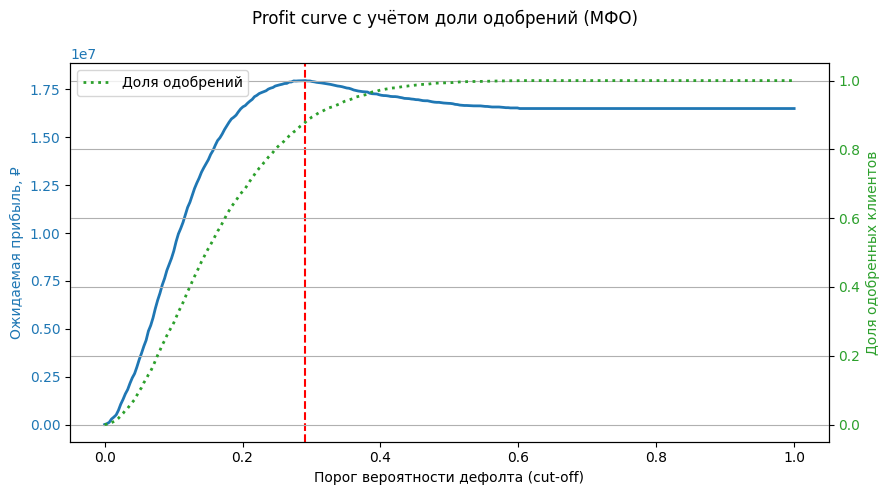


🎯 Для 60% одобрений нужно выбрать порог PD ≈ 0.174
При этом ожидаемая прибыль: 15,403,318 ₽


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Генерация данных клиентов
# -----------------------------
np.random.seed(42)
n = 5000

pd_pred = np.random.beta(a=2, b=10, size=n)          # вероятность дефолта
loan_amount = np.random.uniform(3000, 50000, size=n) # сумма займа
loan_term = np.random.choice([1, 2, 3], size=n, p=[0.6, 0.3, 0.1])  # срок займа
monthly_rate = 0.20  # месячная ставка 20%
loss_recovery = 0.25  # возвращается 25% тела кредита

# -----------------------------
# 2. Экономика по каждому клиенту
# -----------------------------
revenue_good = loan_amount * monthly_rate * loan_term
loss_bad = (1 - loss_recovery) * loan_amount

expected_profit = (1 - pd_pred) * revenue_good - pd_pred * loss_bad

df = pd.DataFrame({
    "pd": pd_pred,
    "loan_amount": loan_amount,
    "term": loan_term,
    "expected_profit": expected_profit
})

# -----------------------------
# 3. Прибыль и доля одобрений при разных порогах
# -----------------------------
thresholds = np.linspace(0, 1, 300)
portfolio_profit = []
approval_rate = []

for t in thresholds:
    accepted = df[df["pd"] <= t]
    portfolio_profit.append(accepted["expected_profit"].sum())
    approval_rate.append(len(accepted) / n)

portfolio_profit = np.array(portfolio_profit)
approval_rate = np.array(approval_rate)

# -----------------------------
# 4. Оптимальный порог по прибыли
# -----------------------------
best_idx = np.argmax(portfolio_profit)
best_threshold = thresholds[best_idx]
best_profit = portfolio_profit[best_idx]
best_approval = approval_rate[best_idx]

print(f"📊 Оптимальный порог PD: {best_threshold:.3f}")
print(f"💰 Ожидаемая прибыль: {best_profit:,.0f} ₽")
print(f"✅ Доля одобренных клиентов: {best_approval*100:.1f}%")

# -----------------------------
# 5. Визуализация
# -----------------------------
fig, ax1 = plt.subplots(figsize=(9,5))

color = 'tab:blue'
ax1.set_xlabel("Порог вероятности дефолта (cut-off)")
ax1.set_ylabel("Ожидаемая прибыль, ₽", color=color)
ax1.plot(thresholds, portfolio_profit, color=color, lw=2, label="Прибыль портфеля")
ax1.axvline(best_threshold, color='red', linestyle='--', label=f"Оптимум = {best_threshold:.3f}")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # вторая ось Y для доли одобрений
color = 'tab:green'
ax2.set_ylabel("Доля одобренных клиентов", color=color)
ax2.plot(thresholds, approval_rate, color=color, lw=2, linestyle=':', label="Доля одобрений")
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Profit curve с учётом доли одобрений (МФО)")
fig.tight_layout()
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

# -----------------------------
# 6. Альтернатива: выбрать порог под заданную долю одобрений
# -----------------------------
target_approval = 0.6  # хотим 60% одобрений
idx = np.argmin(np.abs(approval_rate - target_approval))
target_threshold = thresholds[idx]

print(f"\n🎯 Для {target_approval*100:.0f}% одобрений нужно выбрать порог PD ≈ {target_threshold:.3f}")
print(f"При этом ожидаемая прибыль: {portfolio_profit[idx]:,.0f} ₽")


In [66]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 9.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.9 MB/s eta 0:00:0000:0100:01
